# Import Package

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
#!pip install tqdm
from tqdm import tqdm #progress bar
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats
import time
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
#! pip install xgboost
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.stattools import adfuller
from matplotlib.ticker import FuncFormatter
import statsmodels.formula.api as smf
from google.colab import drive
import math
import calendar
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [10]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FuncFormatter
import plotly.express as px
import plotly.io as pio

# Read Data

In [3]:
# import excel data from google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # import excel data from capstone_APAN folder
# excel_file = pd.ExcelFile('/content/drive/MyDrive/capstone_APAN/RC Projection data since 2022 28AUG24.xlsx')
# sheets_to_load = ['2022', '2023', '2024', 'Workday Calendar', 'Location hierarchy', 'Fleet Count']

# dfs = {}
# for sheet in tqdm(sheets_to_load, desc='Loading sheets'):
#   dfs[sheet] = pd.read_excel(excel_file, sheet_name = sheet)

# df_2022 = dfs['2022']
# df_2023 = dfs['2023']
# df_2024 = dfs['2024']
# workday_calendar = dfs['Workday Calendar']
# location_df = dfs['Location hierarchy']
# fleet_count = dfs['Fleet Count']

In [ ]:
# file_path = '/content/drive/MyDrive/capstone_APAN/df_total.csv'
# df_total.to_csv(file_path, index=False)

In [4]:
# import excel data from capstone_APAN folder
excel_file = pd.ExcelFile('/content/drive/MyDrive/capstone_APAN/RC Projection data since 2022 28AUG24.xlsx')
sheets_to_load = ['Workday Calendar', 'Location hierarchy', 'Fleet Count']

dfs = {}
for sheet in tqdm(sheets_to_load, desc='Loading sheets'):
  dfs[sheet] = pd.read_excel(excel_file, sheet_name = sheet)

workday_calendar = dfs['Workday Calendar']
location_df = dfs['Location hierarchy']
fleet_count = dfs['Fleet Count']

Loading sheets:  67%|██████▋   | 2/3 [00:03<00:01,  1.54s/it]Exception ignored in: <function _xla_gc_callback at 0x7e5b289c7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Loading sheets: 100%|██████████| 3/3 [00:10<00:00,  3.66s/it]


In [5]:
# df_total = pd.concat([df_2022, df_2023, df_2024], axis=0, ignore_index=True)
# df_total = df_total.loc[:, ~df_total.columns.str.contains('^Unnamed')]

workday_months = workday_calendar[['MONTH', 'WD_IN_MNTH', 'DAYS_IN_MNTH', 'SATURDAY_COUNT', 'WEEKDAY_HOLIDAYS']]
workday_months = workday_months.dropna(how='all')

workday_days = workday_calendar[['MONTH.1', 'DT', 'DT_KEY', 'WD_IN_MNTH.1', 'DAYS_IN_MNTH.1', 'SATURDAY_COUNT.1', 'WEEKDAY_HOLIDAYS.1',
                                'Saturdays in Month', 'Workdays in Month', 'Max Workday', 'Max Saturday',
                                'WD Remaining', 'Saturday Remaining']]

In [6]:
df_total = pd.read_csv('/content/drive/MyDrive/capstone_APAN/df_total.csv')

In [7]:
df_total['MONTH'] = pd.to_datetime(df_total['MONTH'])
df_total['YEAR'] = pd.to_datetime(df_total['YEAR'])
df_total['GL_TRANSACTION_EFFECTIVE_DT'] = pd.to_datetime(df_total['GL_TRANSACTION_EFFECTIVE_DT'])
df_total.head()

,MONTH,YEAR,GL_TRANSACTION_EFFECTIVE_DT,GL_EFF_WD_NBR,FIN_SOURCE_TYPE_DESC,LOCATION_CD,LOCATION_DESC,BU_DESC,REGION_DESC,TRANSACTION_AMOUNT
0,2022-01-01,2022-01-01,2022-01-02,0,INTERDISTRICT BILLING,514,TUPELO,OPS - MID SOUTH BU,OPS-SOUTH REGION,52.0
1,2022-01-01,2022-01-01,2022-01-02,0,INTERDISTRICT BILLING,1554,MANSFIELD,OPS - GREAT LAKES BU,OPS-NORTH REGION,52.0
2,2022-01-01,2022-01-01,2022-01-02,0,INTERDISTRICT BILLING,30,LANDOVER MD,OPS - DMV BU,OPS-NORTH REGION,52.0
3,2022-01-01,2022-01-01,2022-01-02,0,INTERDISTRICT BILLING,284,BRIDGETON MISSOURI,OPS - GREAT PLAINS BU,OPS-CENTRAL REGION,208.0
4,2022-01-01,2022-01-01,2022-01-02,0,INTERDISTRICT BILLING,1278,SANFORD NC,OPS - CAROLINAS BU,OPS-SOUTH REGION,52.0


# EDA

In [8]:
def eda_plot(df_total, level=None, description=None, transacation_type=None):

  # description = description.strip().upper()
  transacation_type = transacation_type.strip().upper()

  if level == 'region':
    df_filtered = df_total[df_total['REGION_DESC'] == description]

  if level == 'BU':
    df_filtered = df_total[df_total['BU_DESC'] == description]

  if level == 'location':
    df_filtered = df_total[df_total['LOCATION_DESC'] == description]

  df_filtered = df_filtered[df_filtered['FIN_SOURCE_TYPE_DESC'] == transacation_type]
  # print(df_filtered)
  df_filtered = df_filtered.groupby(['MONTH'])['TRANSACTION_AMOUNT'].sum().reset_index()
  df_filtered['Year'] = df_filtered['MONTH'].dt.year
  df_filtered['Month'] = df_filtered['MONTH'].dt.month

  plt.figure(figsize=(12, 8))

  max_amount = df_filtered['TRANSACTION_AMOUNT'].max()

  if max_amount > 10000:

    def thousands(x, pos):
      return '%1.0fK' % (x * 1e-3)

    formatter = FuncFormatter(thousands)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands))


  for year in [2022, 2023, 2024]:
    df_year = df_filtered[df_filtered['Year'] == year]
    plt.plot(df_year['Month'], df_year['TRANSACTION_AMOUNT'], label=f'Year {year}')

  plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

  plt.grid(True, linestyle='--', alpha=0.7)
  plt.xlabel('Month')
  plt.ylabel('Total Transaction Amount', fontsize = 14)
  plt.title('West Region (Repair Orders) Transaction Amount Over Time', fontsize = 16)
  plt.legend(fontsize=12)
  plt.tight_layout()
  plt.show()

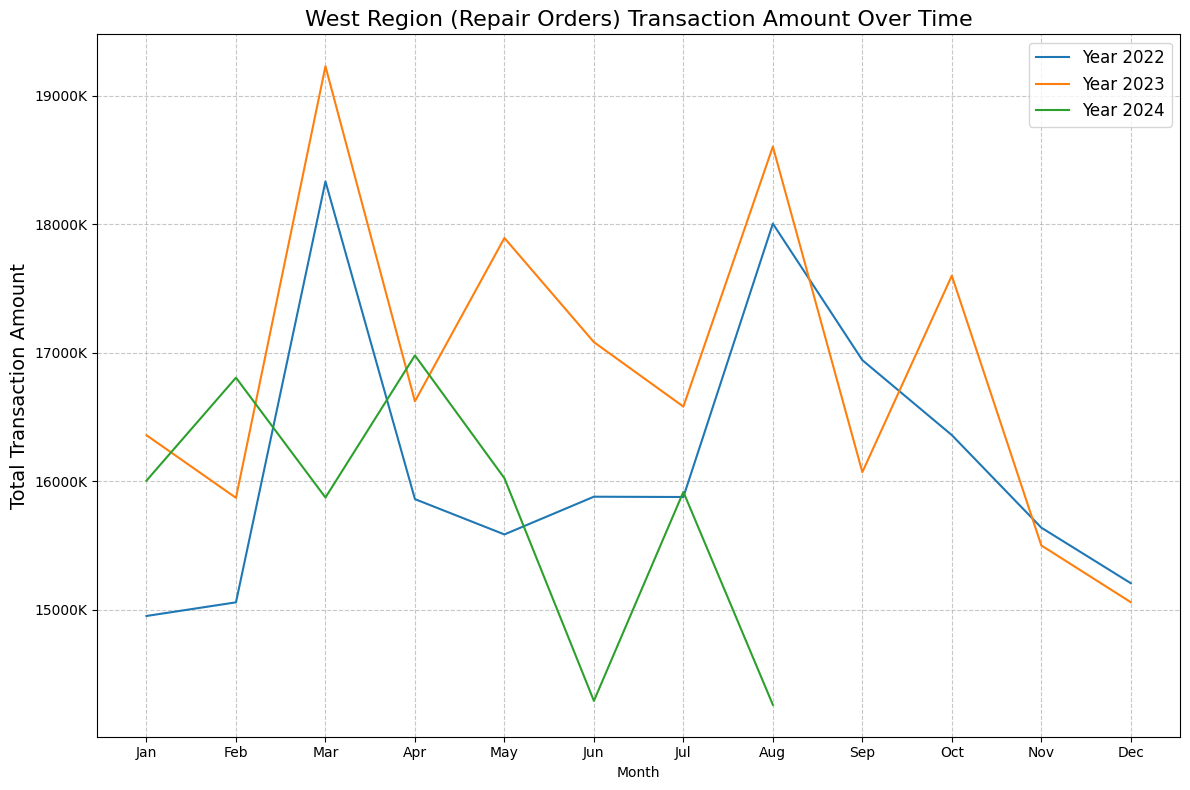

In [9]:
eda_plot(df_total, level = 'region', description='OPS-CENTRAL REGION ', transacation_type = 'repair orders')

In [11]:
def eda_plot_interactive(df_total, level=None, description=None, transaction_type=None):

    level = level.lower() if level else None
    transaction_type = transaction_type.upper() if transaction_type else None
    description = description.upper() if description else None

    if level == 'national':
        df_filtered = df_total

    elif level == 'region':
        df_filtered = df_total[df_total['REGION_DESC'] == description]

    elif level == 'bu':
        df_filtered = df_total[df_total['BU_DESC'] == description]

    elif level == 'location':
        df_filtered = df_total[df_total['LOCATION_DESC'] == description]

    else:
        df_filtered = df_total

    if transaction_type:
        df_filtered = df_filtered[df_filtered['FIN_SOURCE_TYPE_DESC'] == transaction_type]

    # print(df_filtered)
    df_filtered = df_filtered[df_filtered['FIN_SOURCE_TYPE_DESC'] == transaction_type]
    df_filtered = df_filtered.groupby(['MONTH'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['Year'] = df_filtered['MONTH'].dt.year
    df_filtered['Month'] = df_filtered['MONTH'].dt.month

    # Calculate fixed axis ranges
    min_month = df_filtered['Month'].min()
    max_month = df_filtered['Month'].max()
    min_amount = df_filtered['TRANSACTION_AMOUNT'].min()
    max_amount = df_filtered['TRANSACTION_AMOUNT'].max()

    # Create interactive Plotly line plot with fixed axis ranges
    fig = px.line(
        df_filtered,
        x='Month',
        y='TRANSACTION_AMOUNT',
        color='Year',
        title=f'{level.capitalize()} - {description} ({transaction_type}) Transaction Amount Over Time',
        labels={'TRANSACTION_AMOUNT': 'Total Transaction Amount', 'Month': 'Month'},
        line_shape='linear'
    )

    # Set fixed axis ranges
    fig.update_xaxes(range=[min_month, max_month])
    fig.update_yaxes(range=[min_amount, max_amount])

    return fig

In [12]:
eda_plot_interactive(df_total, level='region', description='OPS-CENTRAL REGION ', transaction_type = 'rEPAIR ORDERS')

# Linear Regression

## Automation Function for all level

In [13]:
def generate_prediction_all(df_total, month, year, level='national', region=None, BU=None, location=None, days_to_predict=10):
  metrics_list = []
  predictions_list = []

  # Filter Time
  df_filtered = df_total[(df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.month == month) &
                           (df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.year == year)]

  # National Level
  if level == 'national':
    df_filtered = df_filtered.groupby('GL_TRANSACTION_EFFECTIVE_DT')['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # Region Level
  elif level == 'region' and region is not None:
    # df_filtered['REGION_DESC'] = df_filtered['REGION_DESC'].str.strip().str.lower()
    df_filtered.loc[:, 'REGION_DESC'] = df_filtered['REGION_DESC'].str.strip().str.upper()
    region = region.strip().upper()
    df_filtered = df_filtered[df_filtered['REGION_DESC'] == region]
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT','REGION_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # BU level
  elif level == 'BU' and BU is not None:
    # df_filtered['BU_DESC'] = df_filtered['BU_DESC'].str.strip().str.lower()
    df_filtered.loc[:, 'BU_DESC'] = df_filtered['BU_DESC'].str.strip().str.upper()
    BU = BU.strip().upper()
    df_filtered = df_filtered[df_filtered['BU_DESC'] == BU]
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT','BU_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # Location level
  elif level == 'location' and location is not None:
    df_filtered.loc[:, 'LOCATION_DESC']= df_filtered['LOCATION_DESC'].str.strip().str.upper()
    location = location.strip().upper()
    df_filtered = df_filtered[df_filtered['LOCATION_DESC'] == location]
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT','LOCATION_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # print(df_filtered.head(10))

  if df_filtered.empty:
    return None, None, None

  df_filtered['date_ordinal'] = df_filtered['GL_TRANSACTION_EFFECTIVE_DT'].map(lambda x: x.toordinal())

  monthly_cost_actual = df_filtered['TRANSACTION_AMOUNT'].sum()
  monthly_cost = np.array([df_filtered['TRANSACTION_AMOUNT'].sum()])

  num_days_in_month = calendar.monthrange(year, month)[1]

  actual_days_to_predict = days_to_predict-1 if days_to_predict < num_days_in_month else days_to_predict # avoid cumulative less one day
  X = df_filtered[['date_ordinal']].iloc[:actual_days_to_predict]
  #print(X)
  y = df_filtered['cumulative_daily_cost'].iloc[:actual_days_to_predict]
  #print(y)

  x_value = df_filtered['date_ordinal'].iloc[-1] # End of Month Date Ordinal
  x_test = pd.DataFrame({'date_ordinal': [x_value]})

  if len(X) < 2:
    return None, None, None

  linear_model = LinearRegression()
  linear_model.fit(X, y)

  y_pred = linear_model.predict(x_test)
  y_pred_train = linear_model.predict(X)

  # Get the intercept and coefficients
  intercept = linear_model.intercept_
  coefficients = linear_model.coef_

  mse_train = mean_squared_error(y, y_pred_train)  # MSE
  rmse_train = np.sqrt(mse_train)  # Calculate RMSE manually
  mae_train = mean_absolute_error(y, y_pred_train)
  r2_train = r2_score(y, y_pred_train)
  mape_train = np.mean(np.abs((y - y_pred_train) / y)) * 100

  mse_test = mean_squared_error(monthly_cost, y_pred)
  rmse_test = np.sqrt(mse_test)
  mae_test = mean_absolute_error(monthly_cost, y_pred)
  #r2_test = r2_score(monthly_cost, y_pred)
  mape_test = np.mean(np.abs((monthly_cost - y_pred) / monthly_cost)) * 100

  metrics_list.append({'month': month, 'year': year,
                       'rmse_train': rmse_train, 'mae_train': mae_train, 'r2_train': r2_train, 'mape_train': mape_train,
                       'rmse_test': rmse_test, 'mae_test':mae_test, 'mape_test': mape_test})

  predictions_list.append({'month': month, 'year': year, 'y_actual_start': y_pred_train[0], 'y_actual':monthly_cost_actual, 'y_pred': y_pred[0]})

  return df_filtered, metrics_list, predictions_list

## Flatten Function

In [14]:
def flatten_predictions_metrics(data):
    flattened_data = []

    for entry in data:
        # Extract region or location
        region_or_location = entry.get('region') or entry.get('location', None)
        day = entry.get('day', None)
        category = entry.get('category', None)

        # Flatten metrics
        if entry['metrics'] is not None and len(entry['metrics']) > 0:
            metrics = entry['metrics'][0]  # Assuming metrics is a list with one dictionary
            rmse_train = metrics.get('rmse_train', None)
            mae_train = metrics.get('mae_train', None)
            r2_train = metrics.get('r2_train', None)
            mape_train = metrics.get('mape_train', None)
            rmse_test = metrics.get('rmse_test', None)
            mae_test = metrics.get('mae_test', None)
            mape_test = metrics.get('mape_test', None)
            month = metrics.get('month', None)
            year = metrics.get('year', None)
        else:
            rmse_train, mae_train, r2_train, mape_train, rmse_test, mae_test, mape_test, month, year = [None] * 9

        # Flatten predictions
        if entry['predictions'] is not None and len(entry['predictions']) > 0:
            predictions = entry['predictions'][0]  # Assuming predictions is a list with one dictionary
            y_actual_start = predictions.get('y_actual_start', None)
            y_actual = predictions.get('y_actual', None)
            y_pred = predictions.get('y_pred', None)
        else:
            y_actual_start, y_actual, y_pred = [None] * 3

        # Append the flattened data as a dictionary
        flattened_data.append({
            'region_or_location': region_or_location,
            'day': day,
            'rmse_train': rmse_train,
            'mae_train': mae_train,
            'r2_train': r2_train,
            'mape_train': mape_train,
            'rmse_test': rmse_test,
            'mae_test': mae_test,
            'mape_test': mape_test,
            'month': month,
            'year': year,
            'y_actual_start': y_actual_start,
            'y_actual': y_actual,
            'y_pred': y_pred,
            'category': category
        })

    # Convert the flattened data into a DataFrame
    return pd.DataFrame(flattened_data)

## Accuracy over time

In [15]:
regions = df_total['REGION_DESC'].unique()
region_result = []

for day in range(5,16):
  for region in regions:
    df_filtered, metrics, predictions = generate_prediction_all(df_total, month=1, year=2024, level='region', region=region, days_to_predict=day)

    region_result.append({'region': region, 'day': day, 'metrics': metrics, 'predictions': predictions})

In [ ]:
region_result_df = flatten_predictions_metrics(region_result)

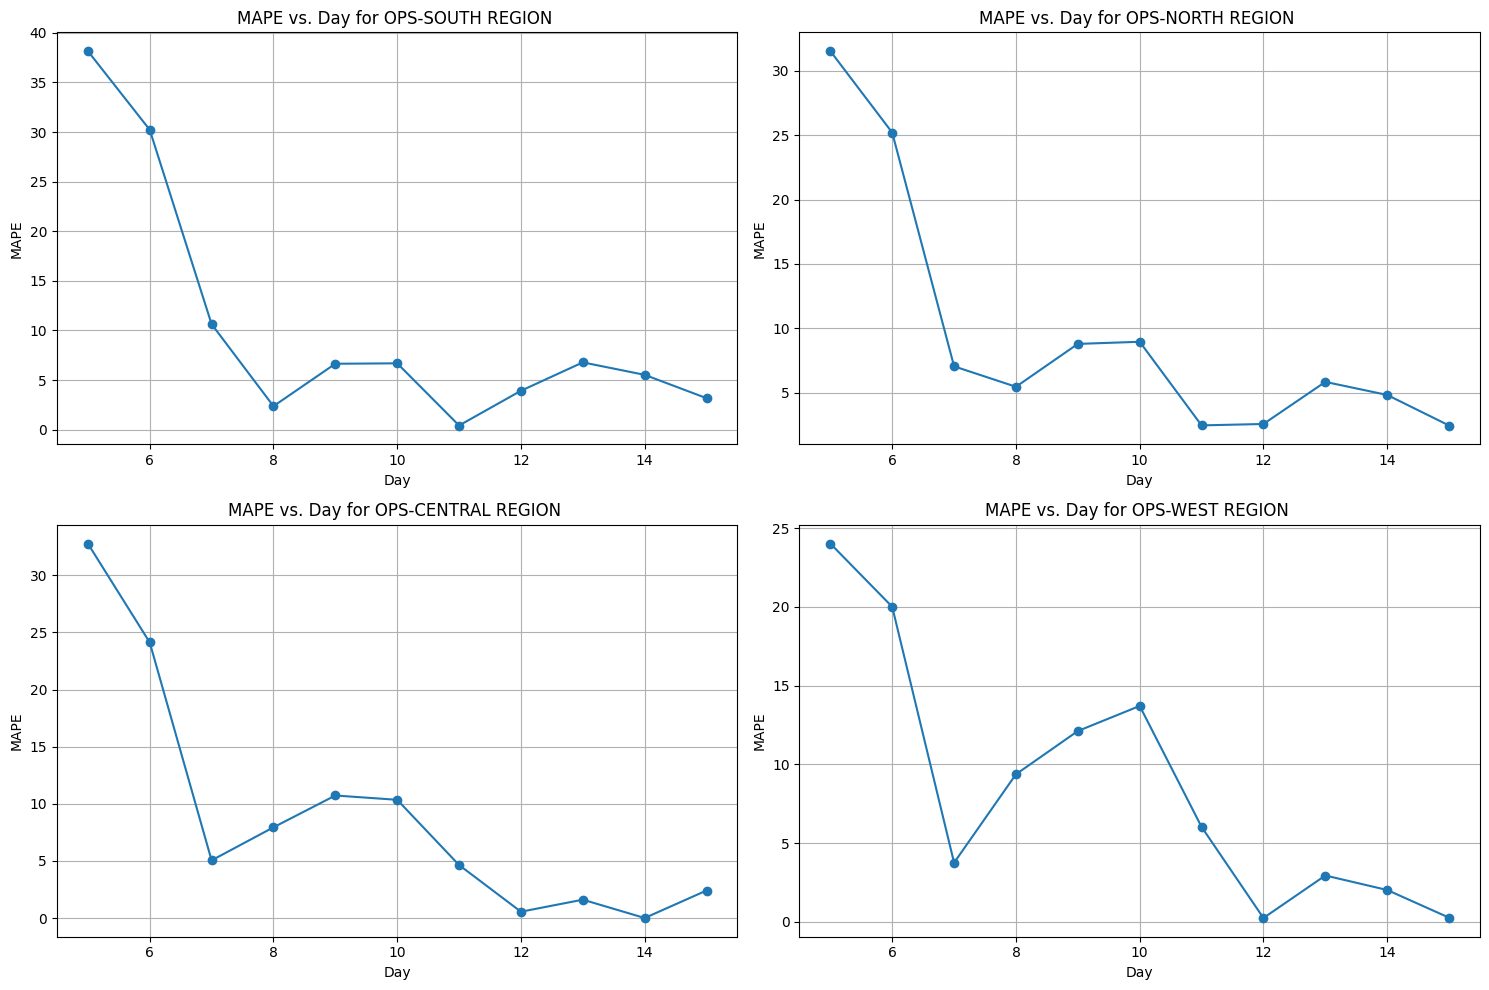

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axes = axes.flatten()

for i, region in enumerate(regions):
    region_data = region_result_df[region_result_df['region_or_location'] == region]
    axes[i].plot(region_data['day'], region_data['mape_test'], marker='o', linestyle='-')
    axes[i].set_xlabel('Day')
    axes[i].set_ylabel('MAPE')
    axes[i].set_title(f'MAPE vs. Day for {region}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Breakdown Cost Type

In [ ]:
def generate_region_category_predictions(df_total, month, year):
    regions = df_total['REGION_DESC'].unique()
    categories = df_total['FIN_SOURCE_TYPE_DESC'].unique()

    region_category_predictions = []

    for region in regions:
        region_df = df_total[df_total['REGION_DESC'] == region]

        for category in categories:

            region_category_df = region_df[region_df['FIN_SOURCE_TYPE_DESC'] == category]

            df_filtered, metrics_list, predictions_list = generate_prediction_all(
                region_category_df, month=month, year=year, level='region', region=region
            )

            if metrics_list is not None and predictions_list is not None:

                region_category_predictions.append({
                    'region': region,
                    'category': category,
                    'metrics': metrics_list,
                    'predictions': predictions_list
                })

    return region_category_predictions

In [16]:
all_prediction = []

for month in range(1,8):
  region_category_predictions = generate_region_category_predictions(df_total, month=month, year=2024)
  df_region_category_predictions = flatten_predictions_metrics(region_category_predictions)
  all_prediction.append(df_region_category_predictions)

df_combined = pd.concat(all_prediction, ignore_index=True)

In [ ]:
testest = df_combined.sort_values(by='mape_test', ascending=True)
testest.dropna(subset=['mape_test'], inplace=True)
testest = testest[(testest['mape_test'] >= 0.000001) & (testest['mape_test'] <= 5.000000)]
testest.groupby(['category', 'month-year']).size().reset_index(name='frequency')

,category,month-year,frequency
0,CAPITALIZATION WRITE OFFS,2-2024,1
1,CREDIT JOURNALS FROM FIS,1-2024,2
2,CREDIT JOURNALS FROM FIS,2-2024,1
3,CREDIT JOURNALS FROM FIS,3-2024,1
4,CREDIT JOURNALS FROM FIS,4-2024,1
5,CREDIT JOURNALS FROM FIS,5-2024,1
6,CREDIT JOURNALS FROM FIS,6-2024,1
7,ELECTRONIC INVOICES,1-2024,2
8,ELECTRONIC INVOICES,2-2024,1
9,ELECTRONIC INVOICES,5-2024,1


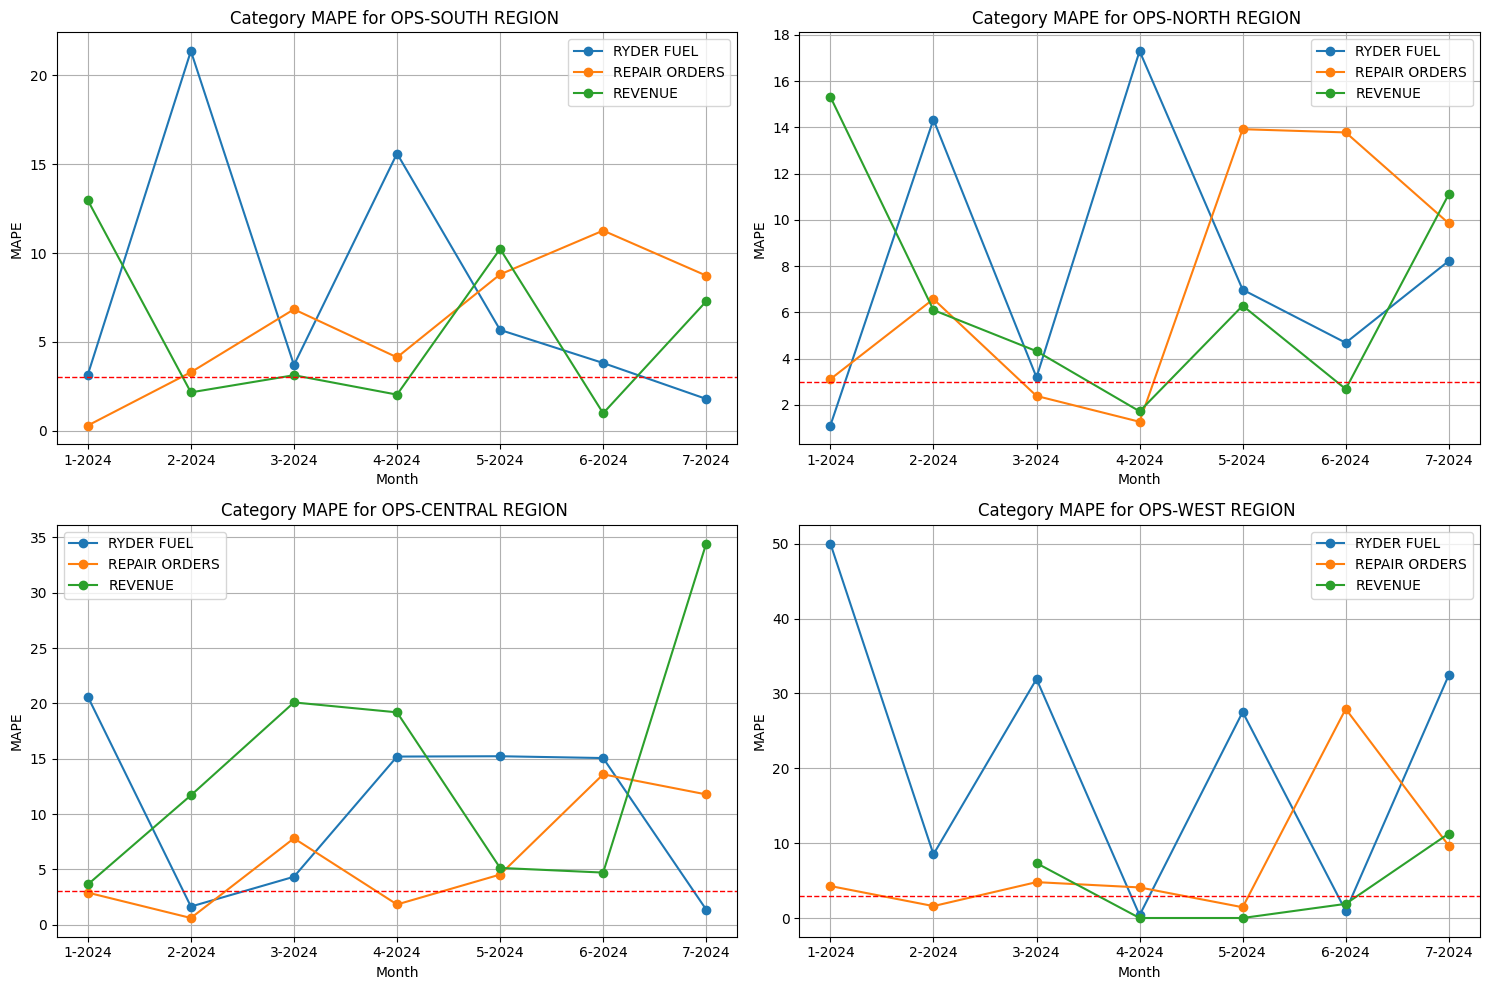

In [ ]:
df_combined['month-year'] = df_combined['month'].astype(str) + '-' + df_combined['year'].astype(str)
categories = ['RYDER FUEL', 'REPAIR ORDERS', 'REVENUE']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axes = axes.flatten()

for i, region in enumerate(regions):
  df_region = df_combined[df_combined['region_or_location'] == region]
  for category in categories:
    df_category = df_region[df_region['category'] == category]
    axes[i].plot(df_category['month-year'], df_category['mape_test'], marker='o', linestyle='-', label=category)

  axes[i].axhline(y=3, color='red', linestyle='--', linewidth=1)

  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('MAPE')
  axes[i].set_title(f'Category MAPE for {region}')
  axes[i].legend()
  axes[i].grid(True)

plt.tight_layout()
plt.show()

## Full Funcation Version

In [17]:
def generate_prediction_all_type(df_total, month, year, level='national', region=None, BU=None, location=None, days_to_predict=10, transacation_type=None):
  metrics_list = []
  predictions_list = []

  # Filter Time
  df_filtered = df_total[(df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.month == month) &
                           (df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.year == year)]

  if transacation_type is not None:
    transacation_type = transacation_type.strip().upper()
    df_filtered = df_filtered[df_filtered['FIN_SOURCE_TYPE_DESC'] == transacation_type]
  # print(df_filtered.head())
  level = level.lower() if level else None
  # National Level
  if level == 'national':
    df_filtered = df_filtered.groupby('GL_TRANSACTION_EFFECTIVE_DT')['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # Region Level
  elif level == 'region' and region is not None:
    # df_filtered['REGION_DESC'] = df_filtered['REGION_DESC'].str.strip().str.lower()
    df_filtered.loc[:, 'REGION_DESC'] = df_filtered['REGION_DESC'].str.strip().str.upper()
    region = region.strip().upper()
    df_filtered = df_filtered[df_filtered['REGION_DESC'] == region]
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT', 'FIN_SOURCE_TYPE_DESC', 'REGION_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # BU level
  elif level == 'bu' and BU is not None:
    # df_filtered['BU_DESC'] = df_filtered['BU_DESC'].str.strip().str.lower()
    df_filtered.loc[:, 'BU_DESC'] = df_filtered['BU_DESC'].str.strip().str.upper()
    BU = BU.strip().upper()
    df_filtered = df_filtered[df_filtered['BU_DESC'] == BU]
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT','BU_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # Location level
  elif level == 'location' and location is not None:
    df_filtered.loc[:, 'LOCATION_DESC']= df_filtered['LOCATION_DESC'].str.strip().str.upper()
    location = location.strip().upper()
    df_filtered = df_filtered[df_filtered['LOCATION_DESC'] == location]
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT','LOCATION_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # print(df_filtered.head(10))

  if df_filtered.empty:
    return None, None, None

  df_filtered['date_ordinal'] = df_filtered['GL_TRANSACTION_EFFECTIVE_DT'].map(lambda x: x.toordinal())

  monthly_cost_actual = df_filtered['TRANSACTION_AMOUNT'].sum()
  monthly_cost = np.array([df_filtered['TRANSACTION_AMOUNT'].sum()])

  num_days_in_month = calendar.monthrange(year, month)[1]

  actual_days_to_predict = days_to_predict-1 if days_to_predict < num_days_in_month else days_to_predict # avoid cumulative less one day
  X = df_filtered[['date_ordinal']].iloc[:actual_days_to_predict]
  # print(f'final X is\n', X)
  y = df_filtered['cumulative_daily_cost'].iloc[:actual_days_to_predict]
  # print(f'final y is\n', y)

  x_value = df_filtered['date_ordinal'].iloc[-1] # End of Month Date Ordinal
  x_test = pd.DataFrame({'date_ordinal': [x_value]})

  if len(X) < 2:
    return None, None, None

  linear_model = LinearRegression()
  linear_model.fit(X, y)

  y_pred = linear_model.predict(x_test)
  y_pred_train = linear_model.predict(X)

  # Get the intercept and coefficients
  intercept = linear_model.intercept_
  coefficients = linear_model.coef_

  mse_train = mean_squared_error(y, y_pred_train)  # MSE
  rmse_train = np.sqrt(mse_train)  # Calculate RMSE manually
  mae_train = mean_absolute_error(y, y_pred_train)
  r2_train = r2_score(y, y_pred_train)
  mape_train = np.mean(np.abs((y - y_pred_train) / y)) * 100

  mse_test = mean_squared_error(monthly_cost, y_pred)
  rmse_test = np.sqrt(mse_test)
  mae_test = mean_absolute_error(monthly_cost, y_pred)
  #r2_test = r2_score(monthly_cost, y_pred)
  mape_test = np.mean(np.abs((monthly_cost - y_pred) / monthly_cost)) * 100

  metrics_list.append({'month': month, 'year': year,
                       'rmse_train': rmse_train, 'mae_train': mae_train, 'r2_train': r2_train, 'mape_train': mape_train,
                       'rmse_test': rmse_test, 'mae_test':mae_test, 'mape_test': mape_test})

  predictions_list.append({'month': month, 'year': year, 'y_actual_start': y_pred_train[0], 'y_actual':monthly_cost_actual, 'y_pred': y_pred[0]})

  return df_filtered, metrics_list, predictions_list

### Analysis

In [18]:
generate_prediction_all_type(df_total, month=1, year=2024, level='bu', BU='OPS - MID SOUTH BU ', days_to_predict=12, transacation_type='repair orders')

In [ ]:
regions = df_total['REGION_DESC'].unique()
categories = df_total['FIN_SOURCE_TYPE_DESC'].unique()

category_predcition_all = []

for region in regions:
  for category in categories:
    for month in range(1,8):
      for day in [8,11,12]:
        df_filtered, metrics_list, predictions_list = generate_prediction_all_type(df_total, month=month, year=2024, level='region', region=region, days_to_predict=day, transacation_type=category)

        if metrics_list is not None and predictions_list is not None:
          category_predcition_all.append({'region': region, 'day': day, 'category': category, 'metrics': metrics_list, 'predictions': predictions_list})

df_category_prediction_all = flatten_predictions_metrics(category_predcition_all)

In [ ]:
df_category_prediction_all.to_csv('category_days_region_prediction_all.csv', index=False)

<ipython-input-141-b6f61fa0b1a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_repair_orders['month-year'] = df_repair_orders['month'].astype(str) + '-' + df_repair_orders['year'].astype(str)


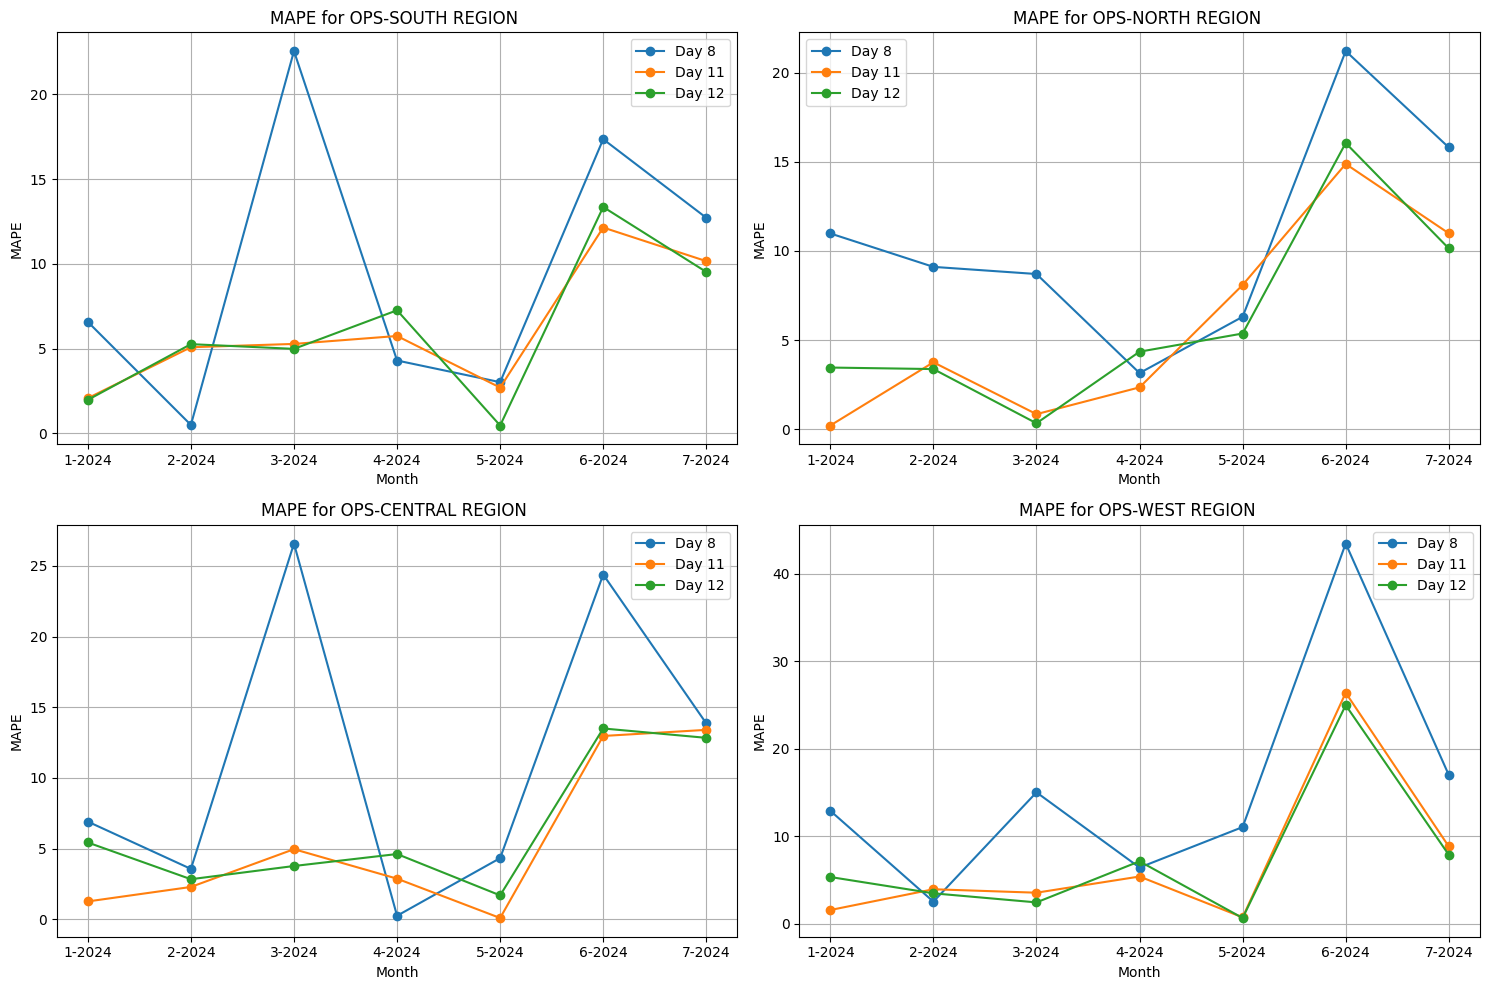

In [ ]:
df_repair_orders = df_category_prediction_all[df_category_prediction_all['category'] == 'REPAIR ORDERS']
df_repair_orders['month-year'] = df_repair_orders['month'].astype(str) + '-' + df_repair_orders['year'].astype(str)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, region in enumerate(regions):
  df_region = df_repair_orders[df_repair_orders['region_or_location'] == region]
  for day in [8, 11, 12]:
    df_day = df_region[df_region['day'] == day]
    axes[i].plot(df_day['month-year'], df_day['mape_test'], marker='o', linestyle='-', label = f'Day {day}')

  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('MAPE')
  axes[i].set_title(f'MAPE for {region}')
  axes[i].grid(True)
  axes[i].legend()

plt.tight_layout()
plt.show()

### Visualization

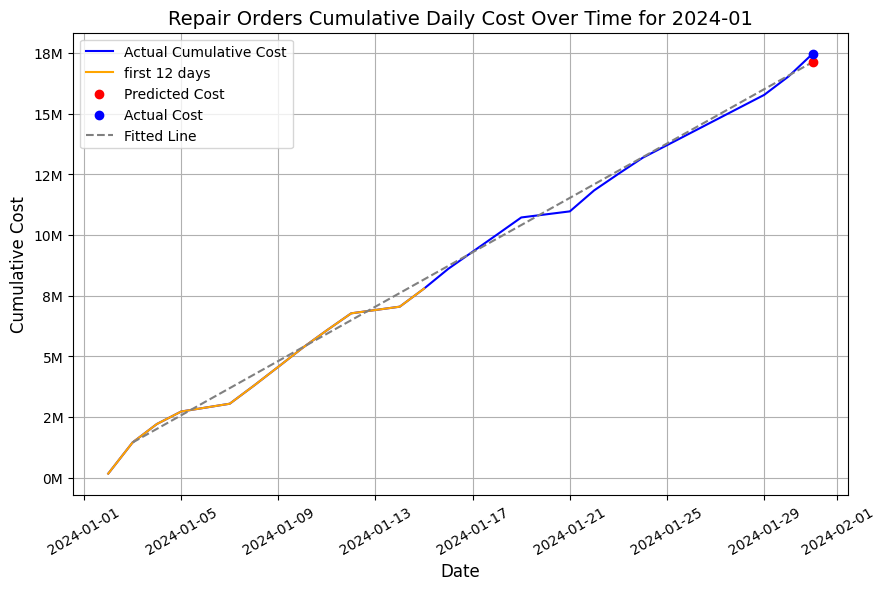

In [ ]:
df_repair_202401 = df_total[(df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.month == 1) &
                           (df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.year == 2024)]
df_repair_202401 = df_repair_202401[df_repair_202401['FIN_SOURCE_TYPE_DESC'] == 'REPAIR ORDERS']
df_repair_202401 = df_repair_202401[df_repair_202401['REGION_DESC'] == 'OPS-SOUTH REGION ']
df_repair_202401 = df_repair_202401.groupby('GL_TRANSACTION_EFFECTIVE_DT')['TRANSACTION_AMOUNT'].sum().reset_index()
df_repair_202401['cumulative_cost'] = df_repair_202401['TRANSACTION_AMOUNT'].cumsum()

predict_row = {'GL_TRANSACTION_EFFECTIVE_DT': pd.to_datetime('2024-01-31'),
           'TRANSACTION_AMOUNT': 941957.02,
           'cumulative_cost': 17127288.91}

df_repair_202401.loc[len(df_repair_202401)] = predict_row

plt.figure(figsize=(10, 6))

def millions(x, pos):
    return '%1.0fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

plt.plot(df_repair_202401['GL_TRANSACTION_EFFECTIVE_DT'][:-1],
         df_repair_202401['cumulative_cost'][:-1],
         color='blue', label='Actual Cumulative Cost')
plt.plot(df_repair_202401['GL_TRANSACTION_EFFECTIVE_DT'][:12],
         df_repair_202401['cumulative_cost'][:12], '-',
         color='orange', label='first 12 days')
plt.scatter(df_repair_202401['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1],
            df_repair_202401['cumulative_cost'].iloc[-1],
            color='red', label='Predicted Cost', zorder=5)
plt.scatter(df_repair_202401['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1],
            df_repair_202401['cumulative_cost'].iloc[-2],
            color='blue', label='Actual Cost', zorder=5)

plt.plot([df_repair_202401['GL_TRANSACTION_EFFECTIVE_DT'].iloc[1],
          df_repair_202401['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1]],
         [df_repair_202401['cumulative_cost'].iloc[1],
          df_repair_202401['cumulative_cost'].iloc[-1]],
         color='gray', linestyle='--', label='Fitted Line')

plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Cost', fontsize=12)
plt.title('Repair Orders Cumulative Daily Cost Over Time for 2024-01', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def generate_prediction_plot(df_filtered, days_to_predict, y_pred):

    df_filtered['GL_TRANSACTION_EFFECTIVE_DT'] = pd.to_datetime(df_filtered['GL_TRANSACTION_EFFECTIVE_DT'])

    # Create traces
    trace_actual = go.Scatter(
        x=df_filtered['GL_TRANSACTION_EFFECTIVE_DT'][:],
        y=df_filtered['cumulative_daily_cost'][:],
        mode='lines+markers',
        name='Actual Cumulative Cost',
        line=dict(color='blue')
    )

    trace_first_N_days = go.Scatter(
        x=df_filtered['GL_TRANSACTION_EFFECTIVE_DT'][:days_to_predict],
        y=df_filtered['cumulative_daily_cost'][:days_to_predict],
        mode='lines',
        name='First {days_to_predict} Days',
        line=dict(color='orange')
    )

    trace_predicted = go.Scatter(
        x=[df_filtered['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1]],
        y=[y_pred],
        mode='markers',
        name='Predicted Cost',
        marker=dict(color='red', size=10)
    )

    trace_actual_last = go.Scatter(
        x=[df_filtered['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1]],
        y=[df_filtered['cumulative_daily_cost'].iloc[-1]],
        mode='markers',
        name='Actual Cost',
        marker=dict(color='blue', size=10)
    )

    # trace_fitted_line = go.Scatter(
    #     x=[df_filtered['GL_TRANSACTION_EFFECTIVE_DT'].iloc[1], df_filtered['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1]],
    #     y=[df_filtered['cumulative_cost'].iloc[1], df_filtered['cumulative_cost'].iloc[-1]],
    #     mode='lines',
    #     name='Fitted Line',
    #     line=dict(color='gray', dash='dash')
    # )

    # Define the layout
    layout = go.Layout(
        title='Repair Orders Cumulative Daily Cost Over Time for 2024-01',
        xaxis=dict(title='Date'),
        yaxis=dict(
            title='Cumulative Cost',
            tickformat='$,.0f'  # Format as millions
        ),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        margin=dict(l=40, r=40, t=40, b=40)
    )

    # Create figure
    fig = go.Figure(data=[trace_actual, trace_first_N_days, trace_predicted, trace_actual_last], layout=layout)
    return fig

In [ ]:
df_filtered2, metrics_list2, prediction_list2 = generate_prediction_all_type(df_total, month=1, year=2024, level='region', region='OPS-WEST REGION ', days_to_predict=12, transacation_type='repair orders')
generate_prediction_plot(df_filtered2, 12, prediction_list2[0]['y_pred'])

### Outlier Detection

In [ ]:
df_grouped = df_total[(df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.month == 1) &
                           (df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.year == 2024)]
df_grouped = df_grouped.groupby(['GL_TRANSACTION_EFFECTIVE_DT', 'REGION_DESC', 'FIN_SOURCE_TYPE_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
df_grouped

,GL_TRANSACTION_EFFECTIVE_DT,REGION_DESC,FIN_SOURCE_TYPE_DESC,TRANSACTION_AMOUNT
0,2024-01-01,OPS-CENTRAL REGION,JOURNAL VOUCHERS,8494.87
1,2024-01-01,OPS-CENTRAL REGION,UNKNOWN,1300.00
2,2024-01-01,OPS-CENTRAL REGION,WALKER ACCOUNTS PAYABLE,10137.33
3,2024-01-01,OPS-NORTH REGION,UNKNOWN,1820.00
4,2024-01-01,OPS-NORTH REGION,WALKER ACCOUNTS PAYABLE,11673.97
...,...,...,...,...
973,2024-01-31,OPS-WEST REGION,RYDER FUEL,4.19
974,2024-01-31,OPS-WEST REGION,SALES JOURNALS,-200.00
975,2024-01-31,OPS-WEST REGION,UNKNOWN,2860.00
976,2024-01-31,OPS-WEST REGION,WALKER ACCOUNTS PAYABLE,170238.51


In [ ]:
df_repair_outliers = df_grouped[df_grouped['FIN_SOURCE_TYPE_DESC'] == 'INTERDISTRICT BILLING']
scaler = StandardScaler()
df_repair_outliers['scaled_amount'] = scaler.fit_transform(df_repair_outliers[['TRANSACTION_AMOUNT']])
dbscan = DBSCAN(eps=1.5, min_samples=50)
df_repair_outliers['outlier'] = dbscan.fit_predict(df_repair_outliers[['scaled_amount']])
df_repair_outliers['is_outlier'] = df_repair_outliers['outlier'].apply(lambda x: True if x == -1 else False)
df_repair_outliers

<ipython-input-61-eef2c43586f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_repair_outliers['scaled_amount'] = scaler.fit_transform(df_repair_outliers[['TRANSACTION_AMOUNT']])
<ipython-input-61-eef2c43586f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_repair_outliers['outlier'] = dbscan.fit_predict(df_repair_outliers[['scaled_amount']])
<ipython-input-61-eef2c43586f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,GL_TRANSACTION_EFFECTIVE_DT,REGION_DESC,FIN_SOURCE_TYPE_DESC,TRANSACTION_AMOUNT,scaled_amount,outlier,is_outlier
12,2024-01-02,OPS-CENTRAL REGION,INTERDISTRICT BILLING,1287.90,-0.382618,0,False
23,2024-01-02,OPS-NORTH REGION,INTERDISTRICT BILLING,2329.06,-0.253978,0,False
33,2024-01-02,OPS-SOUTH REGION,INTERDISTRICT BILLING,17167.07,1.579325,0,False
43,2024-01-02,OPS-WEST REGION,INTERDISTRICT BILLING,6488.05,0.259884,0,False
65,2024-01-03,OPS-NORTH REGION,INTERDISTRICT BILLING,-11000.59,-1.900916,0,False
77,2024-01-03,OPS-SOUTH REGION,INTERDISTRICT BILLING,1526.75,-0.353107,0,False
124,2024-01-04,OPS-SOUTH REGION,INTERDISTRICT BILLING,2990.19,-0.172292,0,False
143,2024-01-05,OPS-CENTRAL REGION,INTERDISTRICT BILLING,734.03,-0.451051,0,False
163,2024-01-05,OPS-SOUTH REGION,INTERDISTRICT BILLING,22345.17,2.219102,-1,True
211,2024-01-08,OPS-CENTRAL REGION,INTERDISTRICT BILLING,1640.95,-0.338997,0,False


In [ ]:
df_repair_outliers[df_repair_outliers['is_outlier'] == True]

,GL_TRANSACTION_EFFECTIVE_DT,REGION_DESC,FIN_SOURCE_TYPE_DESC,TRANSACTION_AMOUNT,scaled_amount,outlier,is_outlier
163,2024-01-05,OPS-SOUTH REGION,INTERDISTRICT BILLING,22345.17,2.219102,-1,True
276,2024-01-09,OPS-SOUTH REGION,INTERDISTRICT BILLING,32086.02,3.422628,-1,True
960,2024-01-31,OPS-SOUTH REGION,INTERDISTRICT BILLING,38728.84,4.243378,-1,True


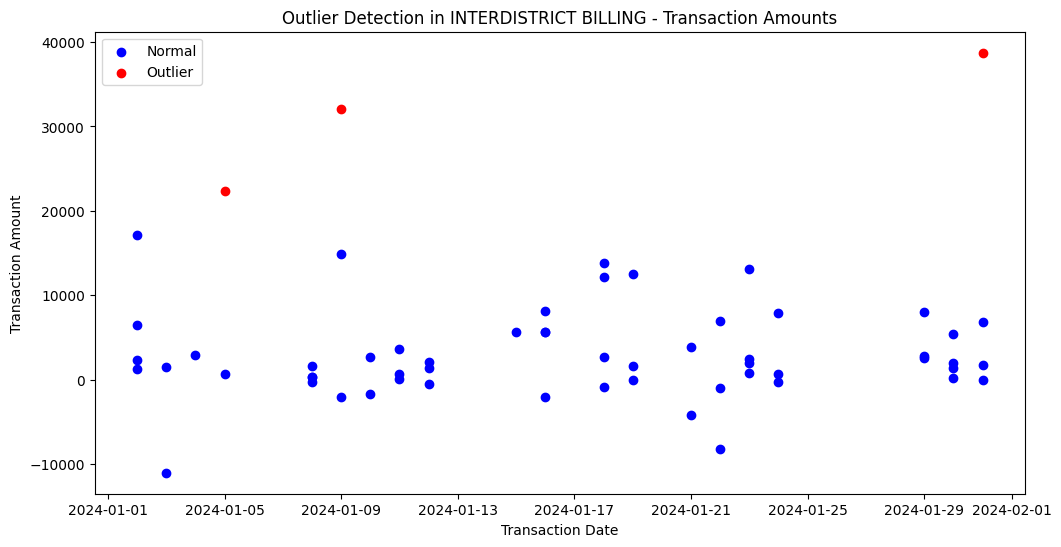

In [ ]:
plt.figure(figsize=(12, 6))

# Plot normal points
plt.scatter(
    df_repair_outliers[df_repair_outliers['is_outlier'] == False]['GL_TRANSACTION_EFFECTIVE_DT'],
    df_repair_outliers[df_repair_outliers['is_outlier'] == False]['TRANSACTION_AMOUNT'],
    color='blue',
    label='Normal'
)

# Plot outliers
plt.scatter(
    df_repair_outliers[df_repair_outliers['is_outlier'] == True]['GL_TRANSACTION_EFFECTIVE_DT'],
    df_repair_outliers[df_repair_outliers['is_outlier'] == True]['TRANSACTION_AMOUNT'],
    color='red',
    label='Outlier'
)

# Adding labels and title
plt.xlabel('Transaction Date')
plt.ylabel('Transaction Amount')
plt.title('Outlier Detection in INTERDISTRICT BILLING - Transaction Amounts')
plt.legend()

# Show plot
plt.show()

In [ ]:
# Outlier detection and removal function
def detect_and_remove_outliers_dbscan(group, eps = 1.5, min_samples = 50):
    scaler = StandardScaler()
    group['scaled_amount'] = scaler.fit_transform(group[['TRANSACTION_AMOUNT']])
    dbscan = DBSCAN(eps=1.5, min_samples=50)
    group['outlier'] = dbscan.fit_predict(group[['scaled_amount']])
    group['is_outlier'] = group['outlier'].apply(lambda x: True if x == -1 else False)
    return group

In [ ]:
def generate_prediction_all_type_outlier_detection(df_total, month, year, level='national', region=None, BU=None, location=None, days_to_predict=10, transacation_type=None):
  metrics_list = []
  predictions_list = []

  # Filter Time
  df_filtered = df_total[(df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.month == month) &
                           (df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.year == year)]

  if transacation_type is not None:
    transacation_type = transacation_type.strip().upper()
    df_filtered = df_filtered[df_filtered['FIN_SOURCE_TYPE_DESC'] == transacation_type]
    df_original = df_filtered.copy()

  # National Level
  if level == 'national':
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT', 'FIN_SOURCE_TYPE_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered = detect_and_remove_outliers_dbscan(df_filtered)
    df_filtered = df_filtered[df_filtered['is_outlier'] == False]
    df_filtered = df_filtered.groupby('GL_TRANSACTION_EFFECTIVE_DT')['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # Region Level
  elif level == 'region' and region is not None:
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT', 'FIN_SOURCE_TYPE_DESC', 'REGION_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered = detect_and_remove_outliers_dbscan(df_filtered)
    df_filtered = df_filtered[df_filtered['is_outlier'] == False]
    df_filtered.loc[:, 'REGION_DESC'] = df_filtered['REGION_DESC'].str.strip().str.upper()
    region = region.strip().upper()
    df_filtered = df_filtered[df_filtered['REGION_DESC'] == region]
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

    df_original.loc[:, 'REGION_DESC'] = df_original['REGION_DESC'].str.strip().str.upper()
    df_original = df_original[df_original['REGION_DESC'] == region]

  # BU level
  elif level == 'BU' and BU is not None:
    # df_filtered['BU_DESC'] = df_filtered['BU_DESC'].str.strip().str.lower()
    df_filtered.loc[:, 'BU_DESC'] = df_filtered['BU_DESC'].str.strip().str.upper()
    BU = BU.strip().upper()
    df_filtered = df_filtered[df_filtered['BU_DESC'] == BU]
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT','BU_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # Location level
  elif level == 'location' and location is not None:
    df_filtered.loc[:, 'LOCATION_DESC']= df_filtered['LOCATION_DESC'].str.strip().str.upper()
    location = location.strip().upper()
    df_filtered = df_filtered[df_filtered['LOCATION_DESC'] == location]
    df_filtered = df_filtered.groupby(['GL_TRANSACTION_EFFECTIVE_DT','LOCATION_DESC'])['TRANSACTION_AMOUNT'].sum().reset_index()
    df_filtered['cumulative_daily_cost'] = df_filtered['TRANSACTION_AMOUNT'].cumsum()

  # print(df_filtered.head(10))

  # df_filtered = df_filtered.groupby('FIN_SOURCE_TYPE_DESC').apply(detect_and_remove_outliers_dbscan).reset_index(drop=True)

  if df_filtered.empty:
    return None, None, None

  df_filtered['date_ordinal'] = df_filtered['GL_TRANSACTION_EFFECTIVE_DT'].map(lambda x: x.toordinal())

  monthly_cost_actual = df_original['TRANSACTION_AMOUNT'].sum()
  monthly_cost = np.array([df_original['TRANSACTION_AMOUNT'].sum()])

  num_days_in_month = calendar.monthrange(year, month)[1]

  actual_days_to_predict = days_to_predict-1 if days_to_predict < num_days_in_month else days_to_predict # avoid cumulative less one day
  X = df_filtered[['date_ordinal']].iloc[:actual_days_to_predict]
  #print(X)
  y = df_filtered['cumulative_daily_cost'].iloc[:actual_days_to_predict]
  #print(y)

  x_value = df_filtered['date_ordinal'].iloc[-1] # End of Month Date Ordinal
  x_test = pd.DataFrame({'date_ordinal': [x_value]})

  if len(X) < 2:
    return None, None, None

  linear_model = LinearRegression()
  linear_model.fit(X, y)

  y_pred = linear_model.predict(x_test)
  y_pred_train = linear_model.predict(X)

  # Get the intercept and coefficients
  intercept = linear_model.intercept_
  coefficients = linear_model.coef_

  mse_train = mean_squared_error(y, y_pred_train)  # MSE
  rmse_train = np.sqrt(mse_train)  # Calculate RMSE manually
  mae_train = mean_absolute_error(y, y_pred_train)
  r2_train = r2_score(y, y_pred_train)
  mape_train = np.mean(np.abs((y - y_pred_train) / y)) * 100

  mse_test = mean_squared_error(monthly_cost, y_pred)
  rmse_test = np.sqrt(mse_test)
  mae_test = mean_absolute_error(monthly_cost, y_pred)
  #r2_test = r2_score(monthly_cost, y_pred)
  mape_test = np.mean(np.abs((monthly_cost - y_pred) / monthly_cost)) * 100

  metrics_list.append({'month': month, 'year': year,
                       'rmse_train': rmse_train, 'mae_train': mae_train, 'r2_train': r2_train, 'mape_train': mape_train,
                       'rmse_test': rmse_test, 'mae_test':mae_test, 'mape_test': mape_test})

  predictions_list.append({'month': month, 'year': year, 'y_actual_start': y_pred_train[0], 'y_actual':monthly_cost_actual, 'y_pred': y_pred[0]})

  return df_filtered, metrics_list, predictions_list

In [ ]:
generate_prediction_all_type_outlier_detection(df_total, 1, 2024, level='region', region='OPS-WEST REGION	', days_to_predict=12, transacation_type='repair orders')

(   GL_TRANSACTION_EFFECTIVE_DT  TRANSACTION_AMOUNT  cumulative_daily_cost  \
 0                   2024-01-02           104267.26              104267.26   
 1                   2024-01-03           614619.91              718887.17   
 2                   2024-01-04           353279.89             1072167.06   
 3                   2024-01-05           302749.33             1374916.39   
 4                   2024-01-07           114550.99             1489467.38   
 5                   2024-01-08           443071.48             1932538.86   
 6                   2024-01-09           193146.66             2125685.52   
 7                   2024-01-10           500636.88             2626322.40   
 8                   2024-01-11           443698.09             3070020.49   
 9                   2024-01-12           301039.21             3371059.70   
 10                  2024-01-14           126061.95             3497121.65   
 11                  2024-01-15           460596.28             

In [ ]:
# Get unique regions and transaction types
unique_regions = df_total['REGION_DESC'].unique()
unique_transaction_types = df_total['FIN_SOURCE_TYPE_DESC'].unique()

# Initialize lists to store results for each function
results_no_outlier_detection = []
results_with_outlier_detection = []

# Loop through each region and transaction type
for region in unique_regions:
    for transaction_type in unique_transaction_types:
        # Run both functions for each combination
        result_no_outlier = generate_prediction_all_type(df_total, month=1, year=2024, level='region', region=region, days_to_predict=12, transacation_type=transaction_type)
        result_with_outlier = generate_prediction_all_type_outlier_detection(df_total, 1, 2024, level='region', region=region, days_to_predict=12, transacation_type=transaction_type)

        # Store results with context (region, transaction type)
        results_no_outlier_detection.append({
            'region': region,
            'category': transaction_type,
            'metrics': result_no_outlier[1],
            'predictions': result_no_outlier[2]
        })

        results_with_outlier_detection.append({
            'region': region,
            'category': transaction_type,
            'metrics': result_with_outlier[1],
            'predictions': result_with_outlier[2]
        })

# Flatten results
flattened_no_outlier_detection = flatten_predictions_metrics(results_no_outlier_detection)
flattened_with_outlier_detection = flatten_predictions_metrics(results_with_outlier_detection)

# Merge for comparison across all regions and transaction types
comparison_df = pd.merge(flattened_no_outlier_detection, flattened_with_outlier_detection,
                         on=['region_or_location', 'day', 'month', 'year', 'category'],
                         suffixes=('_no_outlier', '_with_outlier'))

# Display comparison DataFrame to review differences across regions and transaction types
comparison_columns = [
    'region_or_location', 'category', 'rmse_train_no_outlier', 'rmse_train_with_outlier',
    'mae_train_no_outlier', 'mae_train_with_outlier', 'r2_train_no_outlier', 'r2_train_with_outlier',
    'mape_train_no_outlier', 'mape_train_with_outlier', 'rmse_test_no_outlier', 'rmse_test_with_outlier',
    'mae_test_no_outlier', 'mae_test_with_outlier', 'mape_test_no_outlier', 'mape_test_with_outlier',
    'y_actual_start_no_outlier', 'y_actual_start_with_outlier', 'y_actual_no_outlier', 'y_actual_with_outlier',
    'y_pred_no_outlier', 'y_pred_with_outlier'
]

# Show the filtered comparison results
comparison_df[comparison_columns]

,region_or_location,category,rmse_train_no_outlier,rmse_train_with_outlier,mae_train_no_outlier,mae_train_with_outlier,r2_train_no_outlier,r2_train_with_outlier,mape_train_no_outlier,mape_train_with_outlier,...,mae_test_no_outlier,mae_test_with_outlier,mape_test_no_outlier,mape_test_with_outlier,y_actual_start_no_outlier,y_actual_start_with_outlier,y_actual_no_outlier,y_actual_with_outlier,y_pred_no_outlier,y_pred_with_outlier
0,OPS-SOUTH REGION,INTERDISTRICT BILLING,9700.097400,3403.072633,9019.638386,2631.271952,0.892067,0.886874,19.894813,9.198085,...,13719.079913,114228.463137,8.077528,67.255500,20601.835007,15911.647830,169842.56,169842.56,1.835616e+05,5.561410e+04
1,OPS-SOUTH REGION,WARRANTY CLAIMS,40892.688258,33158.817974,36019.915727,28027.406845,0.964044,0.946301,19.489966,14.357860,...,181736.316475,589835.352795,12.957895,42.055572,-21089.840282,-76489.905643,-1402514.16,-1402514.16,-1.220778e+06,-8.126788e+05
2,OPS-SOUTH REGION,ELECTRONIC INVOICES,16045.076285,16045.076285,12579.132391,12579.132391,0.959391,0.959391,12.306487,12.306487,...,41209.307605,41209.307605,8.684381,8.684381,38182.085344,38182.085344,474522.12,474522.12,5.157314e+05,5.157314e+05
3,OPS-SOUTH REGION,RYDER FUEL,72.409805,72.409805,60.101748,60.101748,0.962365,0.962365,15.176288,15.176288,...,48.651876,48.651876,1.605858,1.605858,223.452312,223.452312,3029.65,3029.65,3.078302e+03,3.078302e+03
4,OPS-SOUTH REGION,WALKER ACCOUNTS PAYABLE,53270.390732,53270.390732,41692.815271,41692.815271,0.977322,0.977322,13.180188,13.180188,...,239893.782274,239893.782274,6.521371,6.521371,121079.434998,121079.434998,3678578.78,3678578.78,3.438685e+06,3.438685e+06
5,OPS-SOUTH REGION,FUEL JOURNALS,1907.355767,1907.355767,1638.507805,1638.507805,0.939742,0.939742,43.493429,43.493429,...,22727.782772,22727.782772,26.634530,26.634530,3876.893495,3876.893495,85332.02,85332.02,6.260424e+04,6.260424e+04
6,OPS-SOUTH REGION,UNKNOWN,2138.261482,2138.261482,1734.982231,1734.982231,0.971791,0.971791,22.522545,22.522545,...,38938.005909,38938.005909,23.747527,23.747527,5965.919546,5965.919546,163966.57,163966.57,1.250286e+05,1.250286e+05
7,OPS-SOUTH REGION,REPAIR ORDERS,351148.668462,351148.668462,324731.023733,324731.023733,0.973013,0.973013,34.322574,34.322574,...,345702.684177,345702.684177,1.978497,1.978497,687876.967712,687876.967712,17472991.59,17472991.59,1.712729e+07,1.712729e+07
8,OPS-SOUTH REGION,JOURNAL VOUCHERS,51915.481556,20809.479197,33565.420259,18750.636424,0.016462,0.211942,246.358090,83.490475,...,10274.823899,227985.979070,6.083619,134.988188,144762.212329,-9547.895402,168893.28,168893.28,1.791681e+05,-5.909270e+04
9,OPS-SOUTH REGION,CREDIT JOURNALS FROM FIS,1877.057055,1877.057055,1547.544757,1547.544757,0.983978,0.983978,6.202056,6.202056,...,2296.303405,2296.303405,2.364750,2.364750,5970.791989,5970.791989,97105.54,97105.54,9.480924e+04,9.480924e+04


In [ ]:
comparison_df_2 = comparison_df[comparison_columns]
comparison_df_2.to_csv('/content/drive/MyDrive/capstone_APAN/comparison_df_2.csv', index=False)

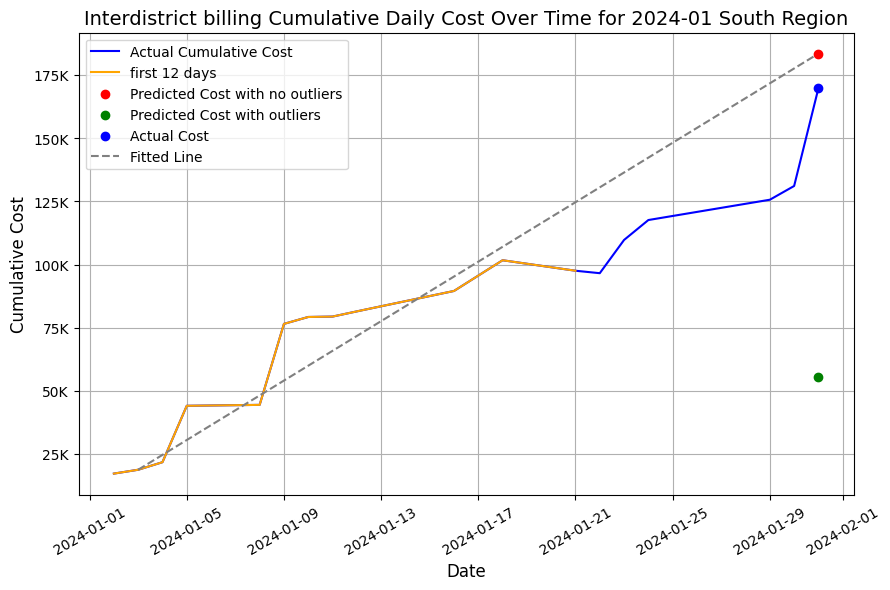

In [ ]:
df_IB_202401 = df_total[(df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.month == 1) &
                           (df_total['GL_TRANSACTION_EFFECTIVE_DT'].dt.year == 2024)]
df_IB_202401 = df_IB_202401[df_IB_202401['FIN_SOURCE_TYPE_DESC'] == 'INTERDISTRICT BILLING']
df_IB_202401 = df_IB_202401[df_IB_202401['REGION_DESC'] == 'OPS-SOUTH REGION ']
df_IB_202401 = df_IB_202401.groupby('GL_TRANSACTION_EFFECTIVE_DT')['TRANSACTION_AMOUNT'].sum().reset_index()
df_IB_202401['cumulative_cost'] = df_IB_202401['TRANSACTION_AMOUNT'].cumsum()

predict_row = {'GL_TRANSACTION_EFFECTIVE_DT': pd.to_datetime('2024-01-31'),
           'TRANSACTION_AMOUNT': 941957.02,
           'cumulative_cost': 183561.6399}

df_IB_202401.loc[len(df_IB_202401)] = predict_row

plt.figure(figsize=(10, 6))

def millions(x, pos):
    return '%1.0fK' % (x * 1e-3)

formatter = FuncFormatter(millions)

plt.plot(df_IB_202401['GL_TRANSACTION_EFFECTIVE_DT'][:-1],
         df_IB_202401['cumulative_cost'][:-1],
         color='blue', label='Actual Cumulative Cost')
plt.plot(df_IB_202401['GL_TRANSACTION_EFFECTIVE_DT'][:12],
         df_IB_202401['cumulative_cost'][:12], '-',
         color='orange', label='first 12 days')
plt.scatter(df_IB_202401['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1],
            df_IB_202401['cumulative_cost'].iloc[-1],
            color='red', label='Predicted Cost with no outliers', zorder=5)
plt.scatter(df_IB_202401['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1],
            55614.09686,
            color='green', label='Predicted Cost with outliers', zorder=5)
plt.scatter(df_IB_202401['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1],
            df_IB_202401['cumulative_cost'].iloc[-2],
            color='blue', label='Actual Cost', zorder=5)

plt.plot([df_IB_202401['GL_TRANSACTION_EFFECTIVE_DT'].iloc[1],
          df_IB_202401['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1]],
         [df_IB_202401['cumulative_cost'].iloc[1],
          df_IB_202401['cumulative_cost'].iloc[-1]],
         color='gray', linestyle='--', label='Fitted Line')

plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Cost', fontsize=12)
plt.title('Interdistrict billing Cumulative Daily Cost Over Time for 2024-01 South Region', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def plot_cum_cost_prediction(df_filtered, predictions_list, month, year, first_n_days=5):

  num_days_in_month = calendar.monthrange(year, month)[1]
  level_info = df_filtered.iloc[0, 1]
  y_start = predictions_list[0]['y_actual_start']
  y_actual = predictions_list[0]['y_actual']
  y_pred = predictions_list[0]['y_pred']
  prediction_day = df_filtered['GL_TRANSACTION_EFFECTIVE_DT'].iloc[-1].strftime('%Y-%m-%d')

  plot_df = pd.DataFrame({'date': df_filtered['GL_TRANSACTION_EFFECTIVE_DT'], 'cumulative_daily_cost': df_filtered['cumulative_daily_cost']})
  plot_df.date = pd.to_datetime(plot_df.date)

  plt.plot(plot_df.date, plot_df.cumulative_daily_cost, '-', color='blue', label='All days except last')
  plt.plot(plot_df.date[:first_n_days], plot_df.cumulative_daily_cost[:first_n_days], '-', color='orange', label=f'First {first_n_days} days')
  plt.plot(plot_df.date.iloc[-1], y_pred, 'ro', label='Prediction (last day)', markersize=5)
  plt.plot(plot_df.date.iloc[-1], y_actual, 'o', color = 'blue', label='Prediction (last day)', markersize=5)
  plt.plot([plot_df.date.iloc[0], plot_df.date.iloc[-1]], [y_start,y_pred], color='green', linestyle='--', label='Slope to y_pred')

  plt.xlabel('Date')
  plt.ylabel('Cost')
  plt.title(f'Cumulative Daily Costs with Prediction by {year}-{month:02d}: {level_info}')

  plt.xticks(rotation=30)
  plt.legend()

  plt.tight_layout
  plt.show()

In [ ]:
df_total['REGION_DESC'].unique()
#df_total['BU_DESC'].unique()

array(['OPS-SOUTH REGION ', 'OPS-NORTH REGION ', 'OPS-CENTRAL REGION ',
       'OPS-WEST REGION '], dtype=object)

<ipython-input-89-d8b60e3eac8c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['LOCATION_DESC'] = df_filtered['LOCATION_DESC'].str.strip().str.lower()


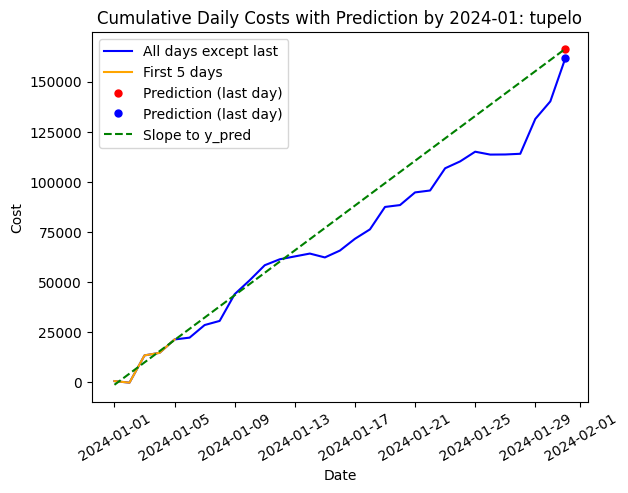

In [ ]:
plot_cum_cost_prediction(df_agg, pred_test, month=1, year=2024, first_n_days=5)